# Example ODE with custom library

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the a non-linear ODE 

We start by importing the required DeepMoD functions:

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt

# DeepMoD functions


from deepymod import DeepMoD
from deepymod.data import Dataset, get_train_test_loader
from deepymod.data.samples import Subsample_random
from deepymod.model.func_approx import NN
from deepymod.model.constraint import LeastSquares
from deepymod.model.sparse_estimators import Threshold, PDEFIND
from deepymod.training import train
from deepymod.training.sparsity_scheduler import TrainTestPeriodic
from scipy.io import loadmat



import torch
from torch.autograd import grad
from itertools import combinations
from functools import reduce
from typing import Tuple
from deepymod.utils.types import TensorList
from deepymod import Library

%load_ext autoreload
%autoreload 2
from scipy.integrate import odeint

# Settings for reproducibility
np.random.seed(40)
torch.manual_seed(0)

# Configuring GPU or CPU
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
device="cpu"
print(device)

cpu


Next, we prepare the dataset. The set of ODEs we consider here are
$d[y, z]/dt = [z, -z+ 5 \sin y]$ 

In [2]:
def dU_dt_sin(U, t):
    return [U[1], -1*U[1] - 5*np.sin(U[0])]

def create_data(U0=[2.5, 0.4], ts=np.linspace(0, 5, 1000)):
    Y = torch.from_numpy(odeint(dU_dt_sin, U0, ts)).float()
    T = torch.from_numpy(ts.reshape(-1, 1)).float()
    print(T.shape)
    return T, Y

dataset = Dataset(create_data, preprocess_kwargs={"noise":0.1},normalize_coords=True, normalize_data=True, device=device)

torch.Size([1000, 1])
device:  cpu


Here we can potentially rescale the Y and T axis and we plot the results

In [3]:
None

Let's plot it to get an idea of the data:

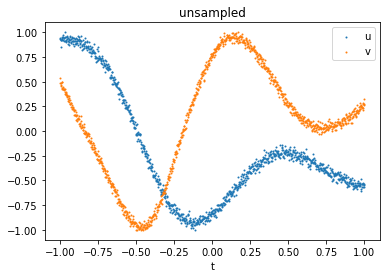

In [4]:
fig, ax = plt.subplots()
ax.scatter(dataset.coords.cpu(), dataset.data[:, 0].cpu(), label="u", s=1)
ax.scatter(dataset.coords.cpu(), dataset.data[:, 1].cpu(), label="v", s=1)
ax.set_xlabel('t')
ax.legend()
ax.set_title("unsampled")
plt.show()

We can now do the same, but subsample the data:

In [5]:
dataset = Dataset(create_data, subsampler=Subsample_random, subsampler_kwargs={"number_of_samples":200}, preprocess_kwargs={"noise":0.1},normalize_coords=True, normalize_data=True, device=device)

torch.Size([1000, 1])
device:  cpu


Now we need to split our data into a train and test dataset: 

In [6]:
train_dataloader, test_dataloader = get_train_test_loader(
    dataset, train_test_split=0.5
)

# Setup a custom library

In this notebook we show how the user can create a custom build library.The library function, $\theta$, in this case contains $[1,u,v, sin(u)]$ to showcase that non-linear terms can easily be added to the library

In [7]:
from torch.autograd import grad
from itertools import combinations, product
from functools import reduce

In [8]:
class Library_nonlinear(Library):
    """[summary]

    Args:
        Library ([type]): [description]
    """
    def __init__(self) -> None:
        super().__init__()

    def library(self, input: Tuple[torch.Tensor, torch.Tensor]) -> Tuple[TensorList, TensorList]:
    
        prediction, data = input
        samples = prediction.shape[0]
        poly_list = []
        deriv_list = []
        time_deriv_list = []
        
        
        # Construct the theta matrix
        C = torch.ones_like(prediction[:,0]).view(samples, -1)
        u = prediction[:,0].view(samples, -1)
        v = prediction[:,1].view(samples, -1)
        theta = torch.cat((C, u, v, torch.sin(u)),dim=1)
    
        # Construct a list of time_derivatives 
        time_deriv_list = []
        for output in torch.arange(prediction.shape[1]):
            dy = grad(prediction[:,output], data, grad_outputs=torch.ones_like(prediction[:,output]), create_graph=True)[0]
            time_deriv = dy[:, 0:1]
            time_deriv_list.append(time_deriv)
        
        return time_deriv_list, [theta,theta]


## Configuring DeepMoD

Configuration of the function approximator: Here the first argument is the number of input and the last argument the number of output layers.

In [9]:
network = NN(1, [30, 30, 30,30], 2)

Configuration of the library function: We select the custom build library we created earlier 

In [10]:
library = Library_nonlinear() 

Configuration of the sparsity estimator and sparsity scheduler used. In this case we use the most basic threshold-based Lasso estimator and a scheduler that asseses the validation loss after a given patience. If that value is smaller than 1e-5, the algorithm is converged.  

In [11]:
estimator = Threshold(0.5) 
sparsity_scheduler = TrainTestPeriodic(periodicity=50, patience=200, delta=1e-5) 

Configuration of the sparsity estimator 

In [12]:
constraint = LeastSquares() 
# Configuration of the sparsity scheduler

Now we instantiate the model and select the optimizer 

In [13]:
model = DeepMoD(network, library, estimator, constraint)

# Defining optimizer
optimizer = torch.optim.Adam(model.parameters(), betas=(0.99, 0.99), amsgrad=True, lr=1e-3) 


## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [14]:
train(model, train_dataloader, test_dataloader, optimizer,sparsity_scheduler, log_dir='runs/coupled2/', split=0.8,  max_iterations=100000, delta=1e-3, patience=100) 

data_train torch.Size([1, 1])
target_train torch.Size([1, 2])
torch.Size([1, 1])
Q tensor([[1.]], grad_fn=<QrBackward>) R tensor([[ 1.0000, -0.1153, -0.1100, -0.1150]], grad_fn=<QrBackward>)


RuntimeError: A must be batches of square matrices, but they are 4 by 1 matrices

Now that DeepMoD has converged, it has found the following numbers:

In [ ]:
model.sparsity_masks

In [ ]:
print(model.estimator_coeffs())